# 第 13 章 中文实体识别实战

## 13.1 人民日报实体识别

### 13.1.1 数据集

In [4]:
import random
import operator
import collections

import numpy as np
import pandas as pd

from typing import List, Dict, Tuple

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

%matplotlib inline

def read_net_data(file_path: str) -> Tuple[List[List[str]], List[List[str]]]:
    x_data, y_data = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()
        x, y = [], []
        for line in lines:
            rows = line.split(' ')
            if len(rows) == 1:
                x_data.append(x)
                y_data.append(y)
                x = []
                y = []
            else:
                x.append(rows[0])
                y.append(rows[1])
    return x_data, y_data


train_x, train_y = read_net_data('data/peoples-daily-ner/example.train')
valid_x, valid_y = read_net_data('data/peoples-daily-ner/example.dev')
test_x, test_y = read_net_data('data/peoples-daily-ner/example.test')

In [5]:
class Processor(object):

    def build_token_dict(self, corpus: List[List[str]]):
        """
        构建 token 字典，这个方法将会遍历分词后的语料，构建一个标记频率字典和标记与索引的映射字典

        Args:
            corpus: 所有分词后的语料
        """
        token2idx = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<BOS>': 2,
            '<EOS>': 3
        }

        token2count = {}
        for sentence in corpus:
            for token in sentence:
                count = token2count.get(token, 0)
                token2count[token] = count + 1
        # 按照词频降序排序
        sorted_token2count = sorted(token2count.items(),
                                    key=operator.itemgetter(1),
                                    reverse=True)
        token2count = collections.OrderedDict(sorted_token2count)

        for token in token2count.keys():
            if token not in token2idx:
                token2idx[token] = len(token2idx)
        return token2idx, token2count

    @staticmethod
    def numerize_sequences(sequence: List[str],
                           token2index: Dict[str, int]) -> List[int]:
        """
        将分词后的标记（token）数组转换成对应的索引数组
        如 ['我', '想', '睡觉'] -> [10, 313, 233]

        Args:
            sequence: 分词后的标记数组
            token2index: 索引词典
        Returns: 输入数据对应的索引数组
        """
        token_result = []
        for token in sequence:
            token_index = token2index.get(token)
            if token_index is None:
                token_index = token2index['<UNK>']
            token_result.append(token_index)
        return token_result

In [6]:
p = Processor()

# 使用全部语料构建输入词表
p.token2idx, p.token2count = p.build_token_dict(train_x + valid_x + test_x)

# 构建标签词表
label2idx = {
    '<PAD>': 0
}

all_label_data = train_y + valid_y + test_y
for sequence in all_label_data:
    for label in sequence:
        if label not in label2idx:
            label2idx[label] = len(label2idx)

p.label2idx = label2idx
p.idx2label = dict([(v, k) for k, v in p.label2idx.items()])

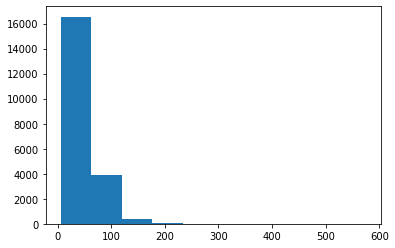

max length: 574


In [7]:
seq_len_list = [len(seq) for seq in train_x]
plt.figure()
plt.hist(seq_len_list)
plt.show()
print(f"max length: {max(seq_len_list)}")

In [8]:
# 序列长度
SEQ_LEN = 100

def process_dataset(x_set, y_set):
    x_set_num = [p.numerize_sequences(seq, p.token2idx) for seq in x_set]
    y_set_num = [p.numerize_sequences(lab, p.label2idx) for lab in y_set]

    # 补全序列长度
    x_set_pad = pad_sequences(x_set_num, SEQ_LEN, padding='post', truncating='post')
    y_set_pad = pad_sequences(y_set_num, SEQ_LEN, padding='post', truncating='post')

    # 标签序列转换为 one-hot 表示
    y_set_one = to_categorical(y_set_pad, len(p.label2idx))

    return x_set_pad, y_set_one


train_x_tensor, train_y_tensor = process_dataset(train_x, train_y)
valid_x_tensor, valid_y_tensor = process_dataset(valid_x, valid_y)
test_x_tensor, test_y_tensor = process_dataset(test_x, test_y)

### 13.1.2 训练模型

In [9]:
TOKEN_COUNT = len(p.token2idx)
LABEL_COUNT = len(p.label2idx)
EMBEDDING_DIM = 64
HIDDEN_DIM = 64

L = tf.keras.layers

inputs = L.Input((SEQ_LEN, ), name='input_layer')
embedding_layer = L.Embedding(input_dim=TOKEN_COUNT,
                              output_dim=EMBEDDING_DIM,
                              name='embedding_layer')
bi_lstm_layer = L.Bidirectional(L.LSTM(HIDDEN_DIM,
                                       return_sequences=True))
dense_layer = L.Dense(LABEL_COUNT, activation=tf.nn.softmax)

tensor = embedding_layer(inputs)
tensor = bi_lstm_layer(tensor)
outputs = dense_layer(tensor)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 100, 64)           286016    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          66048     
_________________________________________________________________
dense (Dense)                (None, 100, 8)            1032      
Total params: 353,096
Trainable params: 353,096
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(train_x_tensor,
          train_y_tensor,
          validation_data=(train_x_tensor, train_y_tensor),
          epochs=10,
          batch_size=256)

Epoch 1/10
82/82 [==============================] - 32s 388ms/step - loss: 0.6112 - accuracy: 0.8441 - val_loss: 0.2482 - val_accuracy: 0.9462
Epoch 2/10
82/82 [==============================] - 30s 364ms/step - loss: 0.2195 - accuracy: 0.9478 - val_loss: 0.1900 - val_accuracy: 0.9488
Epoch 3/10
82/82 [==============================] - 31s 378ms/step - loss: 0.1688 - accuracy: 0.9508 - val_loss: 0.1517 - val_accuracy: 0.9530
Epoch 4/10
82/82 [==============================] - 31s 378ms/step - loss: 0.1420 - accuracy: 0.9551 - val_loss: 0.1310 - val_accuracy: 0.9583
Epoch 5/10
82/82 [==============================] - 31s 376ms/step - loss: 0.1219 - accuracy: 0.9611 - val_loss: 0.1105 - val_accuracy: 0.9641
Epoch 6/10
82/82 [==============================] - 29s 350ms/step - loss: 0.1031 - accuracy: 0.9667 - val_loss: 0.0936 - val_accuracy: 0.9698
Epoch 7/10
82/82 [==============================] - 27s 325ms/step - loss: 0.0877 - accuracy: 0.9721 - val_loss: 0.0793 - val_accuracy: 0.9748

### 13.1.3 评估序列标注

In [8]:
loss, acc = model.evaluate(test_x_tensor, test_y_tensor, batch_size=512, verbose=0)
print(f"lost: {loss}, accuracy: {acc}")

lost: 0.06724640882611789, accuracy: 0.9784641861915588


In [9]:
from seqeval.metrics import classification_report

def predict(sequences: List[List[str]]):
    """
    预测序列标注结果
    Args:
        sequences: 文本序列数组
    Returns:
        文本序列的标注数组
    """
    len_list = [len(seq) for seq in sequences]
    x_set_num = [p.numerize_sequences(seq, p.token2idx) for seq in sequences]

    # 补全序列长度
    x_set_pad = pad_sequences(x_set_num, SEQ_LEN, padding='post', truncating='post')

    predicts = model.predict(x_set_pad)
    predict_labels = predicts.argmax(-1)

    result = []
    for index, label_idx in enumerate(predict_labels):
        label_idx = label_idx[:len_list[index]]
        labels = [p.idx2label[idx] for idx in label_idx]
        result.append(labels)
    return result

# 由于模型只能处理一定长度的序列，需要对原始标签也进行截断
y_true = [y[:SEQ_LEN] for y in test_y]
y_pred = predict(test_x)

In [10]:
print(classification_report(y_true, y_pred))

           precision    recall  f1-score   support

      PER       0.51      0.61      0.55      1798
      LOC       0.52      0.52      0.52      3431
      ORG       0.31      0.43      0.36      2148

micro avg       0.45      0.51      0.48      7377
macro avg       0.46      0.51      0.48      7377



## 13.2 BERT 迁移学习实体识别

### 13.2.1 tf.keras 加载 BERT 模型

In [13]:
import os
# 需要设定环境变量来使用 tf.keras 作为后端
os.environ['TF_KERAS'] = '1'
from keras_bert import load_trained_model_from_checkpoint

SEQ_LEN = 100
BERT_PATH = 'data/bert/chinese_L-12_H-768_A-12'

config_path = os.path.join(BERT_PATH, 'bert_config.json')
checkpoint_path = os.path.join(BERT_PATH, 'bert_model.ckpt')

bert_model = load_trained_model_from_checkpoint(config_path,
                                                checkpoint_path,
                                                seq_len=SEQ_LEN, # 序列长度
                                                output_layer_num=4) # 提取特征层数
bert_model.summary(line_length=120)

Model: "model_2"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
Input-Token (InputLayer)               [(None, 100)]              0                                                     
________________________________________________________________________________________________________________________
Input-Segment (InputLayer)             [(None, 100)]              0                                                     
________________________________________________________________________________________________________________________
Embedding-Token (TokenEmbedding)       [(None, 100, 768), (21128, 16226304      Input-Token[0][0]                       
________________________________________________________________________________________________________________________
Embedding-Segme

In [14]:
import os
import codecs
from typing import List

class BERTProcessor(object):

    def read_vocab_list(self, bert_folder: str):
        """
        读取 BERT 词表
        Args:
            bert_folder: BERT 模型文件夹路径
        """
        dict_path = os.path.join(bert_folder, 'vocab.txt')
        token_dict = {}
        with codecs.open(dict_path, 'r', 'utf8') as reader:
            for line in reader:
                token = line.strip()
                token_dict[token] = len(token_dict)

        self.token2idx = token_dict

    def build_label_dict(self, y_data):
        """
        构建标签词表
        Args:
            y_data: 标签数据数组
        """
        # 构建标签词表，需要增加一个特殊标志 [PAD] 用于标记补全位
        label2idx = {
            '[PAD]': 0
        }

        for sequence in y_data:
            for label in sequence:
                if label not in label2idx:
                    label2idx[label] = len(label2idx)

        self.label2idx = label2idx
        self.idx2label = dict([(v, k) for k, v in label2idx.items()])

    def numerize_sequences(self, sequence: List[str], token2idx: Dict[str, int]) -> List[int]:
        """
        将分词后的标记（token）数组转换成对应的索引数组
        Args:
            sequence: 分词后的标记数组
        Returns: 输入数据对应的索引数组
        """
        token_result = []
        for token in sequence:
            token_index = token2idx.get(token)
            if token_index is None:
                token_index = token2idx['[UNK]']
            token_result.append(token_index)
        return token_result

bert_processor = BERTProcessor()
bert_processor.read_vocab_list(BERT_PATH)
bert_processor.build_label_dict(train_y + test_y + valid_y)

In [15]:
sentences = [[
    '语', '言', '模', '型'
]]
x_set_num = [p.numerize_sequences(seq, p.token2idx) for seq in sentences]
x_set_pad = pad_sequences(x_set_num, SEQ_LEN, padding='post', truncating='post')
x_segments = np.zeros(x_set_pad.shape)

# 输出句子的特征张量
bert_model.predict((x_set_pad, x_segments))

array([[[ 0.39564452,  0.33022746, -0.43297228, ...,  0.661224  ,
         -1.5728569 , -0.0946451 ],
        [ 1.3865703 , -1.0209625 , -0.81014854, ...,  0.67395735,
         -1.3157052 , -0.2783737 ],
        [ 1.1564046 , -0.9684137 , -0.83766013, ...,  0.7626987 ,
         -1.3007891 , -0.3555608 ],
        ...,
        [ 1.0103469 ,  0.5744371 , -0.2238759 , ...,  0.64004606,
         -1.5287675 , -0.10786324],
        [ 1.0362953 ,  0.6315569 , -0.38111922, ...,  0.65740514,
         -1.5043037 , -0.10978415],
        [ 0.96543396,  0.56763047, -0.2328559 , ...,  0.6472532 ,
         -1.5195591 , -0.11089186]]], dtype=float32)

In [16]:
HIDDEN_DIM = 64

L = tf.keras.layers

bi_lstm_layer = L.Bidirectional(L.LSTM(HIDDEN_DIM,
                                       return_sequences=True))
dense_layer = L.Dense(len(p.label2idx), activation=tf.nn.softmax)

tensor = bi_lstm_layer(bert_model.output)
outputs = dense_layer(tensor)

transfer_model = tf.keras.Model(bert_model.inputs, outputs)
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
# transfer_model.summary()

In [17]:
# 序列长度
SEQ_LEN = 100

def process_bert_dataset(x_set, y_set):
    x_set_num = [bert_processor.numerize_sequences(seq, p.token2idx) for seq in x_set]
    y_set_num = [bert_processor.numerize_sequences(lab, p.label2idx) for lab in y_set]

    # 补全序列长度
    x_set_pad = pad_sequences(x_set_num, SEQ_LEN, padding='post', truncating='post')
    y_set_pad = pad_sequences(y_set_num, SEQ_LEN, padding='post', truncating='post')

    x_segments = np.zeros(x_set_pad.shape)

    # 标签序列转换为 one-hot 表示
    y_set_one = to_categorical(y_set_pad, len(p.label2idx))

    return (x_set_pad, x_segments), y_set_one


train_x_tensor, train_y_tensor = process_bert_dataset(train_x, train_y)
valid_x_tensor, valid_y_tensor = process_bert_dataset(valid_x, valid_y)
test_x_tensor, test_y_tensor = process_bert_dataset(test_x, test_y)

In [ ]:
transfer_model.fit(train_x_tensor,
                   train_y_tensor,
                   validation_data=(valid_x_tensor, valid_y_tensor),
                   batch_size=512,
                   epochs=10)

Epoch 1/10
11/41 [=======>......................] - ETA: 33:29 - loss: 0.3369 - accuracy: 0.4182

In [37]:
def bert_predict(sequences: List[List[str]]) -> List[List[str]]:
    len_list = [len(seq) for seq in sequences]
    x_set_num = [bert_processor.numerize_sequences(seq, p.token2idx) for seq in sequences]

    # 补全序列长度
    x_set_pad = pad_sequences(x_set_num, SEQ_LEN, padding='post', truncating='post')
    x_segments = np.zeros(x_set_pad.shape)

    predicts = transfer_model.predict([x_set_pad, x_segments])
    predict_labels = predicts.argmax(-1)

    result = []
    for index, label_idx in enumerate(predict_labels):
        # 截断预测序列，保持和输入一致
        label_idx = label_idx[:len_list[index]]
        labels = [bert_processor.idx2label[idx] for idx in label_idx]
        result.append(labels)
    return result

In [38]:
y_true = [y[:SEQ_LEN] for y in test_y]
y_pred = bert_predict(test_x)

In [39]:
print(classification_report(y_true, y_pred))

           precision    recall  f1-score   support

      PER       0.88      0.90      0.89      1798
      LOC       0.80      0.85      0.82      3431
      ORG       0.67      0.74      0.70      2148

micro avg       0.78      0.83      0.80      7377
macro avg       0.78      0.83      0.81      7377



In [ ]:
transfer_model.fit(train_x_tensor,
                   train_y_tensor,
                   validation_data=(valid_x_tensor, valid_y_tensor),
                   batch_size=512,
                   epochs=40)

In [ ]:
y_true = [y[:SEQ_LEN] for y in test_y]
y_pred = bert_predict(test_x)
print(classification_report(y_true, y_pred))